<a href="https://colab.research.google.com/github/Ashu156/Neural-time-series-analysis-LFP/blob/main/multitaper_spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa
# Analysis Imports
import math
import numpy as np
from scipy.signal.windows import dpss
from scipy.signal import detrend
# Logistical Imports
import warnings
import timeit
from functools import partial
from multiprocessing import Pool, cpu_count
# Visualization imports
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
### From Prerau lab's multitaper toolbox ###

# MULTITAPER SPECTROGRAM #

def multitaper_spectrogram(data, fs, frequency_range=None, time_bandwidth=5, num_tapers=None, window_params=None,
                           min_nfft=0, detrend_opt='linear', multiprocess=False, cpus=False, weighting='unity',
                           plot_on=True, clim_scale = True, verbose=True, xyflip=False):
    """ Compute multitaper spectrogram of timeseries data
    Usage:
    mt_spectrogram, stimes, sfreqs = multitaper_spectrogram(data, fs, frequency_range=None, time_bandwidth=5,
                                                                   num_tapers=None, window_params=None, min_nfft=0,
                                                                   detrend_opt='linear', multiprocess=False, cpus=False,
                                                                    weighting='unity', plot_on=True, clim_scale=true, 
                                                                    verbose=True, xyflip=False):
        Arguments:
                data (1d np.array): time series data -- required
                fs (float): sampling frequency in Hz  -- required
                frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] (default: [0 nyquist])
                time_bandwidth (float): time-half bandwidth product (window duration*half bandwidth of main lobe)
                                        (default: 5 Hz*s)
                num_tapers (int): number of DPSS tapers to use (default: [will be computed
                                  as floor(2*time_bandwidth - 1)])
                window_params (list): 1x2 list - [window size (seconds), step size (seconds)] (default: [5 1])
                detrend_opt (string): detrend data window ('linear' (default), 'constant', 'off')
                                      (Default: 'linear')
                min_nfft (int): minimum allowable NFFT size, adds zero padding for interpolation (closest 2^x)
                                (default: 0)
                multiprocess (bool): Use multiprocessing to compute multitaper spectrogram (default: False)
                cpus (int): Number of cpus to use if multiprocess = True (default: False). Note: if default is left
                            as False and multiprocess = True, the number of cpus used for multiprocessing will be
                            all available - 1.
                weighting (str): weighting of tapers ('unity' (default), 'eigen', 'adapt');
                plot_on (bool): plot results (default: True)
                clim_scale (bool): automatically scale the colormap on the plotted spectrogram (default: true)
                verbose (bool): display spectrogram properties (default: true)
                xyflip (bool): transpose the mt_spectrogram output (default: false)
        Returns:
                mt_spectrogram (TxF np array): spectral power matrix
                stimes (1xT np array): timepoints (s) in mt_spectrogram
                sfreqs (1xF np array)L frequency values (Hz) in mt_spectrogram
        Example:
        In this example we create some chirp data and run the multitaper spectrogram on it.
            import numpy as np  # import numpy
            from scipy.signal import chirp  # import chirp generation function
            # Set spectrogram params
            fs = 200  # Sampling Frequency
            frequency_range = [0, 25]  # Limit frequencies from 0 to 25 Hz
            time_bandwidth = 3  # Set time-half bandwidth
            num_tapers = 5  # Set number of tapers (optimal is time_bandwidth*2 - 1)
            window_params = [4, 1]  # Window size is 4s with step size of 1s
            min_nfft = 0  # No minimum nfft
            detrend_opt = 'constant'  # detrend each window by subtracting the average
            multiprocess = True  # use multiprocessing
            cpus = 3  # use 3 cores in multiprocessing
            weighting = 'unity'  # weight each taper at 1
            plot_on = True  # plot spectrogram
            clim_scale = False # don't auto-scale the colormap
            verbose = True  # print extra info
            xyflip = False  # do not transpose spect output matrix
            # Generate sample chirp data
            t = np.arange(1/fs, 600, 1/fs)  # Create 10 min time array from 1/fs to 600 stepping by 1/fs
            f_start = 1  # Set chirp freq range min (Hz)
            f_end = 20  # Set chirp freq range max (Hz)
            data = chirp(t, f_start, t[-1], f_end, 'logarithmic')
            # Compute the multitaper spectrogram
            spect, stimes, sfreqs = multitaper_spectrogram(data, fs, frequency_range, time_bandwidth, num_tapers,
                                                           window_params, min_nfft, detrend_opt, multiprocess,
                                                           cpus, weighting, plot_on, clim_scale, verbose, xyflip):
        This code is companion to the paper:
        "Sleep Neurophysiological Dynamics Through the Lens of Multitaper Spectral Analysis"
           Michael J. Prerau, Ritchie E. Brown, Matt T. Bianchi, Jeffrey M. Ellenbogen, Patrick L. Purdon
           December 7, 2016 : 60-92
           DOI: 10.1152/physiol.00062.2015
         which should be cited for academic use of this code.
         A full tutorial on the multitaper spectrogram can be found at:  #   http://www.sleepEEG.org/multitaper
        Copyright 2021 Michael J. Prerau Laboratory. - http://www.sleepEEG.org
        Authors: Michael J. Prerau, Ph.D., Thomas Possidente
        
        Last modified - 2/18/2021 Thomas Possidente
  __________________________________________________________________________________________________________________
    """

    #  Process user input
    [data, fs, frequency_range, time_bandwidth, num_tapers,
     winsize_samples, winstep_samples, window_start,
     num_windows, nfft, detrend_opt, plot_on, verbose] = process_input(data, fs, frequency_range, time_bandwidth,
                                                                       num_tapers, window_params, min_nfft,
                                                                       detrend_opt, plot_on, verbose)

    # Set up spectrogram parameters
    [window_idxs, stimes, sfreqs, freq_inds] = process_spectrogram_params(fs, nfft, frequency_range, window_start,
                                                                          winsize_samples)
    # Display spectrogram parameters
    if verbose:
        display_spectrogram_props(fs, time_bandwidth, num_tapers, [winsize_samples, winstep_samples], frequency_range,
                                  detrend_opt)

    # Split data into segments and preallocate
    data_segments = data[window_idxs]

    # COMPUTE THE MULTITAPER SPECTROGRAM
    #     STEP 1: Compute DPSS tapers based on desired spectral properties
    #     STEP 2: Multiply the data segment by the DPSS Tapers
    #     STEP 3: Compute the spectrum for each tapered segment
    #     STEP 4: Take the mean of the tapered spectra

    # Compute DPSS tapers (STEP 1)
    dpss_tapers, dpss_eigen = dpss(winsize_samples, time_bandwidth, num_tapers, return_ratios=True)
    dpss_eigen = np.reshape(dpss_eigen, (num_tapers, 1))

    # pre-compute weights
    if weighting == 'eigen':
        wt = dpss_eigen / num_tapers
    elif weighting == 'unity':
        wt = np.ones(num_tapers) / num_tapers
        wt = np.reshape(wt, (num_tapers, 1))  # reshape as column vector
    else:
        wt = 0

    tic = timeit.default_timer()  # start timer

    # set all but 1 arg of calc_mts_segment to constant (so we only have to supply one argument later)
    calc_mts_segment_plus_args = partial(calc_mts_segment, dpss_tapers=dpss_tapers, nfft=nfft, freq_inds=freq_inds,
                                         detrend_opt=detrend_opt, num_tapers=num_tapers, dpss_eigen=dpss_eigen,
                                         weighting=weighting, wt=wt)

    if multiprocess:  # use multiprocessing
        if not cpus:  # if cpus not specfied, use all but 1
            pool = Pool(cpu_count()-1)
        else:  # else us specified number
            pool = Pool(cpus)

        # Compute multiprocess multitaper spect.
        mt_spectrogram = pool.map(calc_mts_segment_plus_args, data_segments)
        pool.close()
        pool.join()

    else:  # if no multiprocessing, compute normally
        mt_spectrogram = np.apply_along_axis(calc_mts_segment_plus_args, 1, data_segments)

    # Compute one-sided PSD spectrum
    mt_spectrogram = np.asarray(mt_spectrogram)
    mt_spectrogram = mt_spectrogram.T
    dc_select = np.where(sfreqs == 0)
    nyquist_select = np.where(sfreqs == fs/2)
    select = np.setdiff1d(np.arange(0, len(sfreqs)), [dc_select, nyquist_select])

    mt_spectrogram = np.vstack([mt_spectrogram[dc_select[0], :], 2*mt_spectrogram[select, :],
                               mt_spectrogram[nyquist_select[0], :]]) / fs

    # Flip if requested
    if xyflip:
        mt_spectrogram = np.transpose(mt_spectrogram)

    # End timer and get elapsed compute time
    toc = timeit.default_timer()
    elapsed_time = toc - tic
    if verbose:
        print("\n Multitaper compute time: " + str(elapsed_time) + " seconds")

    # Plot multitaper spectrogram
    if plot_on:

        # Eliminate bad data from colormap scaling
        spect_data = mt_spectrogram
        clim = np.percentile(spect_data, [5, 95])  # Scale colormap from 5th percentile to 95th

        plt.figure(1, figsize=(10, 5))
        librosa.display.specshow(nanpow2db(mt_spectrogram), x_axis='time', y_axis='linear',
                                 x_coords=stimes, y_coords=sfreqs, shading='auto', cmap="jet")
        plt.colorbar(label='Power (dB)')
        plt.xlabel("Time (HH:MM:SS)")
        plt.ylabel("Frequency (Hz)")
        if clim_scale:
            plt.clim(clim)  # actually change colorbar scale
        plt.show()

    # Put outputs into better format for output
    #stimes = np.mat(stimes)
    #sfreqs = np.mat(sfreqs)

    if all(mt_spectrogram.flatten() == 0):
        print("\n Data was all zeros, no output")

    return mt_spectrogram, stimes, sfreqs


# Helper Functions #

# Process User Inputs #
def process_input(data, fs, frequency_range=None, time_bandwidth=5, num_tapers=None, window_params=None, min_nfft=0,
                  detrend_opt='linear', plot_on=True, verbose=True):
    """ Helper function to process multitaper_spectrogram() arguments
            Arguments:
                    data (1d np.array): time series data-- required
                    fs (float): sampling frequency in Hz  -- required
                    frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] (default: [0 nyquist])
                    time_bandwidth (float): time-half bandwidth product (window duration*half bandwidth of main lobe)
                                            (default: 5 Hz*s)
                    num_tapers (int): number of DPSS tapers to use (default: None [will be computed
                                      as floor(2*time_bandwidth - 1)])
                    window_params (list): 1x2 list - [window size (seconds), step size (seconds)] (default: [5 1])
                    min_nfft (int): minimum allowable NFFT size, adds zero padding for interpolation (closest 2^x)
                                    (default: 0)
                    detrend_opt (string): detrend data window ('linear' (default), 'constant', 'off')
                                          (Default: 'linear')
                    plot_on (True): plot results (default: True)
                    verbose (True): display spectrogram properties (default: true)
            Returns:
                    data (1d np.array): same as input
                    fs (float): same as input
                    frequency_range (list): same as input or calculated from fs if not given
                    time_bandwidth (float): same as input or default if not given
                    num_tapers (int): same as input or calculated from time_bandwidth if not given
                    winsize_samples (int): number of samples in single time window
                    winstep_samples (int): number of samples in a single window step
                    window_start (1xm np.array): array of timestamps representing the beginning time for each window
                    num_windows (int): number of windows in the data
                    nfft (int): length of signal to calculate fft on
                    detrend_opt ('string'): same as input or default if not given
                    plot_on (bool): same as input
                    verbose (bool): same as input
    """

    # Make sure data is 1 dimensional np array
    if len(data.shape) != 1:
        if (len(data.shape) == 2) & (data.shape[1] == 1):  # if it's 2d, but can be transferred to 1d, do so
            data = np.ravel(data[:, 0])
        elif (len(data.shape) == 2) & (data.shape[0] == 1):  # if it's 2d, but can be transferred to 1d, do so
            data = np.ravel(data.T[:, 0])
        else:
            raise TypeError("Input data is the incorrect dimensions. Should be a 1d array with shape (n,) where n is \
                            the number of data points. Instead data shape was " + str(data.shape))

    # Set frequency range if not provided
    if frequency_range is None:
        frequency_range = [0, fs / 2]

    # Set detrending method
    detrend_opt = detrend_opt.lower()
    if detrend_opt != 'linear':
        if detrend_opt in ['const', 'constant']:
            detrend_opt = 'constant'
        elif detrend_opt in ['none', 'false']:
            detrend_opt = 'off'
        else:
            raise ValueError("'" + str(detrend_opt) + "' is not a valid argument for detrend_opt. The choices " +
                             "are: 'constant', 'linear', or 'off'.")
    # Check if frequency range is valid
    if frequency_range[1] > fs / 2:
        frequency_range[1] = fs / 2
        warnings.warn('Upper frequency range greater than Nyquist, setting range to [' +
                      str(frequency_range[0]) + ', ' + str(frequency_range[1]) + ']')

    # Set number of tapers if none provided
    if num_tapers is None:
        num_tapers = math.floor(2 * time_bandwidth) - 1

    # Warn if number of tapers is suboptimal
    if num_tapers != math.floor(2 * time_bandwidth) - 1:
        warnings.warn('Number of tapers is optimal at floor(2*TW) - 1. consider using ' +
                      str(math.floor(2 * time_bandwidth) - 1))

    # If no window params provided, set to defaults
    if window_params is None:
        window_params = [5, 1]

    # Check if window size is valid, fix if not
    if window_params[0] * fs % 1 != 0:
        winsize_samples = round(window_params[0] * fs)
        warnings.warn('Window size is not divisible by sampling frequency. Adjusting window size to ' +
                      str(winsize_samples / fs) + ' seconds')
    else:
        winsize_samples = window_params[0] * fs

    # Check if window step is valid, fix if not
    if window_params[1] * fs % 1 != 0:
        winstep_samples = round(window_params[1] * fs)
        warnings.warn('Window step size is not divisible by sampling frequency. Adjusting window step size to ' +
                      str(winstep_samples / fs) + ' seconds')
    else:
        winstep_samples = window_params[1] * fs

    # Get total data length
    len_data = len(data)

    # Check if length of data is smaller than window (bad)
    if len_data < winsize_samples:
        raise ValueError("\nData length (" + str(len_data) + ") is shorter than window size (" +
                         str(winsize_samples) + "). Either increase data length or decrease window size.")

    # Find window start indices and num of windows
    window_start = np.arange(0, len_data - winsize_samples + 1, winstep_samples)
    num_windows = len(window_start)

    # Get num points in FFT
    if min_nfft == 0:  # avoid divide by zero error in np.log2(0)
        nfft = max(2 ** math.ceil(np.log2(abs(winsize_samples))), winsize_samples)
    else:
        nfft = max(max(2 ** math.ceil(np.log2(abs(winsize_samples))), winsize_samples),
                   2 ** math.ceil(np.log2(abs(min_nfft))))

    return ([data, fs, frequency_range, time_bandwidth, num_tapers,
             int(winsize_samples), int(winstep_samples), window_start, num_windows, nfft,
             detrend_opt, plot_on, verbose])


# PROCESS THE SPECTROGRAM PARAMETERS #
def process_spectrogram_params(fs, nfft, frequency_range, window_start, datawin_size):
    """ Helper function to create frequency vector and window indices
        Arguments:
             fs (float): sampling frequency in Hz  -- required
             nfft (int): length of signal to calculate fft on -- required
             frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] -- required
             window_start (1xm np.array): array of timestamps representing the beginning time for each
                                          window -- required
             datawin_size (float): seconds in one window -- required
        Returns:
            window_idxs (nxm np array): indices of timestamps for each window
                                        (nxm where n=number of windows and m=datawin_size)
            stimes (1xt np array): array of times for the center of the spectral bins
            sfreqs (1xf np array): array of frequency bins for the spectrogram
            freq_inds (1d np array): boolean array of which frequencies are being analyzed in
                                      an array of frequencies from 0 to fs with steps of fs/nfft
    """

    # create frequency vector
    df = fs / nfft
    sfreqs = np.arange(0, fs, df)

    # Get frequencies for given frequency range
    freq_inds = (sfreqs >= frequency_range[0]) & (sfreqs <= frequency_range[1])
    sfreqs = sfreqs[freq_inds]

    # Compute times in the middle of each spectrum
    window_middle_samples = window_start + round(datawin_size / 2)
    stimes = window_middle_samples / fs

    # Get indexes for each window
    window_idxs = np.atleast_2d(window_start).T + np.arange(0, datawin_size, 1)
    window_idxs = window_idxs.astype(int)

    return [window_idxs, stimes, sfreqs, freq_inds]


# DISPLAY SPECTROGRAM PROPERTIES
def display_spectrogram_props(fs, time_bandwidth, num_tapers, data_window_params, frequency_range, detrend_opt):
    """ Prints spectrogram properties
        Arguments:
            fs (float): sampling frequency in Hz  -- required
            time_bandwidth (float): time-half bandwidth product (window duration*1/2*frequency_resolution) -- required
            num_tapers (int): number of DPSS tapers to use -- required
            data_window_params (list): 1x2 list - [window length(s), window step size(s)] -- required
            frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] -- required
            detrend_opt (str): detrend data window ('linear' (default), 'constant', 'off')
        Returns:
            This function does not return anything
    """

    data_window_params = np.asarray(data_window_params) / fs

    # Print spectrogram properties
    print("Multitaper Spectrogram Properties: ")
    print('     Spectral Resolution: ' + str(2 * time_bandwidth / data_window_params[0]) + 'Hz')
    print('     Window Length: ' + str(data_window_params[0]) + 's')
    print('     Window Step: ' + str(data_window_params[1]) + 's')
    print('     Time Half-Bandwidth Product: ' + str(time_bandwidth))
    print('     Number of Tapers: ' + str(num_tapers))
    print('     Frequency Range: ' + str(frequency_range[0]) + "-" + str(frequency_range[1]) + 'Hz')
    print('     Detrend: ' + detrend_opt + '\n')


# NANPOW2DB
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB


# Helper #
def is_outlier(data):
    smad = 1.4826 * np.median(abs(data - np.median(data)))  # scaled median absolute deviation
    outlier_mask = abs(data-np.median(data)) > 3*smad  # outliers are more than 3 smads away from median
    outlier_mask = (outlier_mask | np.isnan(data) | np.isinf(data))
    return outlier_mask


# CALCULATE MULTITAPER SPECTRUM ON SINGLE SEGMENT
def calc_mts_segment(data_segment, dpss_tapers, nfft, freq_inds, detrend_opt, num_tapers, dpss_eigen, weighting, wt):
    """ Helper function to calculate the multitaper spectrum of a single segment of data
        Arguments:
            data_segment (1d np.array): One window worth of time-series data -- required
            dpss_tapers (2d np.array): Parameters for the DPSS tapers to be used.
                                       Dimensions are (num_tapers, winsize_samples) -- required
            nfft (int): length of signal to calculate fft on -- required
            freq_inds (1d np array): boolean array of which frequencies are being analyzed in
                                      an array of frequencies from 0 to fs with steps of fs/nfft
            detrend_opt (str): detrend data window ('linear' (default), 'constant', 'off')
            num_tapers (int): number of tapers being used
            dpss_eigen (np array):
            weighting (str):
            wt (int or np array):
        Returns:
            mt_spectrum (1d np.array): spectral power for single window
    """

    # If segment has all zeros, return vector of zeros
    if all(data_segment == 0):
        ret = np.empty(sum(freq_inds))
        ret.fill(0)
        return ret

    # Option to detrend data to remove low frequency DC component
    if detrend_opt != 'off':
        data_segment = detrend(data_segment, type=detrend_opt)

    # Multiply data by dpss tapers (STEP 2)
    tapered_data = np.multiply(np.mat(data_segment).T, np.mat(dpss_tapers.T))

    # Compute the FFT (STEP 3)
    fft_data = np.fft.fft(tapered_data, nfft, axis=0)

    # Compute the weighted mean spectral power across tapers (STEP 4)
    spower = np.power(np.imag(fft_data), 2) + np.power(np.real(fft_data), 2)
    if weighting == 'adapt':
        # adaptive weights - for colored noise spectrum (Percival & Walden p368-370)
        tpower = np.dot(np.transpose(data_segment), (data_segment/len(data_segment)))
        spower_iter = np.mean(spower[:, 0:2], 1)
        spower_iter = spower_iter[:, np.newaxis]
        a = (1 - dpss_eigen) * tpower
        for i in range(3):  # 3 iterations only
            # Calc the MSE weights
            b = np.dot(spower_iter, np.ones((1, num_tapers))) / ((np.dot(spower_iter, np.transpose(dpss_eigen))) +
                                                                 (np.ones((nfft, 1)) * np.transpose(a)))
            # Calc new spectral estimate
            wk = (b**2) * np.dot(np.ones((nfft, 1)), np.transpose(dpss_eigen))
            spower_iter = np.sum((np.transpose(wk) * np.transpose(spower)), 0) / np.sum(wk, 1)
            spower_iter = spower_iter[:, np.newaxis]

        mt_spectrum = np.squeeze(spower_iter)

    else:
        # eigenvalue or uniform weights
        mt_spectrum = np.dot(spower, wt)
        mt_spectrum = np.reshape(mt_spectrum, nfft)  # reshape to 1D

    return mt_spectrum[freq_inds]

In [ ]:
# Import data file from local machine
from google.colab import files
uploaded = files.upload()

Saving seeg_data_pac.npz to seeg_data_pac.npz


In [5]:
# Load data
import os
filename = os.path.join(os.getcwd(), 'seeg_data_pac.npz')
arch = np.load(filename)
data = arch['data']       # data of a single sEEG contact
sf = float(arch['sf'])    # sampling frequency
times = arch['times']     # time vector
print(f"DATA: (n_trials, n_times)={data.shape}; SAMPLING FREQUENCY={sf}Hz; "
      f"TIME VECTOR: n_times={len(times)}")

DATA: (n_trials, n_times)=(160, 4001); SAMPLING FREQUENCY=1024.0Hz; TIME VECTOR: n_times=4001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:268: UserWarning: Window size is not divisible by sampling frequency. Adjusting window size to 0.099609375 seconds
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:276: UserWarning: Window step size is not divisible by sampling frequency. Adjusting window step size to 0.009765625 seconds


Multitaper Spectrogram Properties: 
     Spectral Resolution: 100.3921568627451Hz
     Window Length: 0.099609375s
     Window Step: 0.009765625s
     Time Half-Bandwidth Product: 5
     Number of Tapers: 9
     Frequency Range: 0-512.0Hz
     Detrend: linear


 Multitaper compute time: 0.19231892500010872 seconds


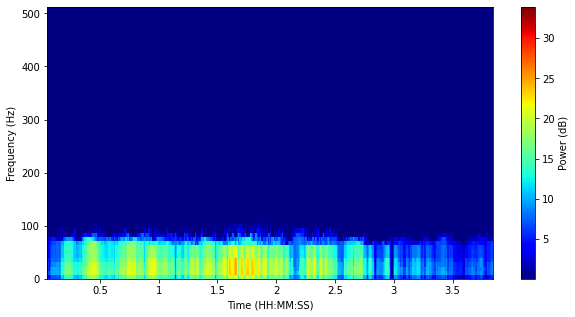

(array([[1.15005184e+00, 2.90474562e+00, 2.04051474e+00, ...,
         3.31479240e+00, 3.66244953e+00, 3.33271683e+00],
        [2.48842072e+00, 5.11290963e+00, 3.80851683e+00, ...,
         6.50022858e+00, 6.96215432e+00, 6.77566134e+00],
        [2.25117086e+00, 3.47020551e+00, 3.14139467e+00, ...,
         6.75484912e+00, 6.86003363e+00, 6.87629112e+00],
        ...,
        [1.01129214e-03, 2.68068641e-03, 7.00475114e-04, ...,
         4.52114660e-04, 2.94570769e-04, 2.95158826e-04],
        [7.56713983e-04, 1.40345332e-03, 1.46232008e-03, ...,
         7.37489332e-04, 2.77481712e-04, 4.74684741e-04],
        [5.27199677e-04, 1.87325586e-04, 8.18382159e-04, ...,
         4.96773689e-04, 1.26249247e-04, 2.64887745e-04]]),
 array([0.04980469, 0.05957031, 0.06933594, 0.07910156, 0.08886719,
        0.09863281, 0.10839844, 0.11816406, 0.12792969, 0.13769531,
        0.14746094, 0.15722656, 0.16699219, 0.17675781, 0.18652344,
        0.19628906, 0.20605469, 0.21582031, 0.22558594, 0.235

In [29]:
import librosa.display
multitaper_spectrogram(data.mean(0), sf, frequency_range=None, time_bandwidth=5, num_tapers=None, window_params= [0.1, 0.01],
                           min_nfft=0, detrend_opt='linear', multiprocess=False, cpus=False, weighting='unity',
                           plot_on=True, clim_scale = True, verbose=True, xyflip=False)